In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate

In [ ]:
# Opción para ver todas las columnas del dataset en el notebook
pd.set_option('display.max_columns', 50)

# Práctico 03: Introducción al aprendizaje automático

Para poder desarrollar nuestro clasificador, comenzaremos con la etapa de preprocesamiento, en el que prepararemos los datos para ser insertados a nuestro modelo. Crearemos nuestro baseline y comenzaremos a crear features nuevas para nuestro modelo.

## Objetivo del práctico

### Preprocesamiento
- Tratamiento de valores nulos
- Estandarización
- Encoding de variables categóricas

### Train-Validation-Test
- División del dataset en train/validation/test
- Estratificación

### Primer modelo baseline

Una vez preparado el dataset nuestra tarea será elegir qué métrica utilizaremos 
y entrenar diferentes modelos.
- ¿Es un dataset balanceado o desbalanceado?
- ¿Qué métrica utilizaremos para medir si funciona el modelo?
- ¿Cómo sabemos si el modelo es útil o no?
- ¿Qué modelos podemos probar? Recordemos que es necesario distinta preparación según el modelo que utilicemos.

### Presentación

Al final del práctico, es necesario hacer 1 o 2 slides que irán incluidos en la presentación final.  
Los slides deberán contener las etapas de preprocesamiento que utilizamos junto al modelo baseline y 
sus respectivas métricas.

### Librerías recomendadas

Utilizaremos principalmente scikit-learn, opcionalmente xgboost y lightgbm.  
Recomiendo el siguiente material:  
- https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ -> Recomiendo los primeros capitulos de este libro. Enseña a usar pipelines.
- https://scikit-learn.org/stable/ -> Referencia de librería scikit-learn. Contiene casi todo lo que vamos a utilizar, pipelines, preprocesamiento y varios modelos.
- https://xgboost.readthedocs.io/en/latest/ -> Librería muy utilizada debido a que tiene muy buenos resultados. Es un tipo de algoritmo "boosting tree"
- https://lightgbm.readthedocs.io/en/latest/ -> Otra librería similar a xgboost, cada vez se usa más, debido a su facilidad de uso y buenos resultados.
- https://www.youtube.com/watch?v=BFaadIqWlAg -> Charla de PyData donde muestra el uso de pipelines

## Práctico 03: Introducción al aprendizaje automático - Resolución

### Leer el dataset

In [ ]:
url = "https://raw.githubusercontent.com/AgusCarchano/Mentorias-grupo1/master/data/bank-additional-full.csv"
df = pd.read_csv(url, sep=";")

### Análisis de las variables

Formalmente, en la base de datos no hay valores nulos o NaN. No obstante, las variables categóricas tienen una categoría "desconocido" que sería el equivalente a un valor nulo. 

Las alternativas de tratamiento posibles son:
- Dejarlos como están, y al efectuar el OneHotEncoder para las variables categóricas pedirle que ignore esa categoría.
- Imputarlos antes de hacer el encoding. Para esta alternativa, podríamos referir a algunos de los métodos de preprocessing para imputación o hacer nuestro CustomTransformer.

En función del modelo que se utilice, se decidirá el curso de acción más conveniente.

#### Estandarización

En cuanto a la estandarización de las variables numéricas, se tienen diferentes opciones, a saber:
- Podrían dejarse en su estado actual.
- Podrían escalarse con alguno de los diferentes métodos disponibles en scikit-learn (MinMax, StandardScaller, RobustScaller en caso de que la variable tenga outliers que no hayamos eliminado).
- Podrían "discretizarse" a partir del método KBinsDiscretizer o Binarizer (en caso de querer diferenciar solo dos grupos a partir de un punto de corte).
- Podríamos eliminar los outliers y luego re-escalarlas.

Algunos modelos como SGDClassifier necesitan que los datos sean previamente estandarizados, otros como DecisionTree no lo requieren. Por esta razón, la determinación del tipo de estandarización a emplear (o no) dependerá del modelo a aplicar para la predicción.

#### Variables categóricas y numéricas

Considerando la totalidad del dataset, en su estado original, podemos diferenciar las variables categóricas y numéricas del siguiente modo. 

In [ ]:
variables_categoricas_original = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
variables_numericas_original = ['age', 'duration', 'campaign', 'pdays', 'previous','emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

No obstante, el grupo de variables se reducirá luego de algunas transformaciones y análisis de correlación. Con lo cual, serán indicados sin la referencia "original".

#### Correlación entre variables

En el práctico 2 se desarrolló un análisis en profundidad de la correlación entre las variables, que nos llevó a tomar las siguientes definiciones:
- Se eliminaran del dataset de análisis tres variables por presentar alta correlación: 'emp.var.rate', 'cons.price.idx', 'nr.employed'.

Adicionalmente, se detectaron inconsistencias y muchos datos faltantes en la variable 'pdays', lo cual sumado a que la variable no resulta muy relevante para el análisis que se plantea, se optó por dejarla de lado.

La falta de información para identificar la fecha exacta de la última llamada, sumado al hecho de que las variables día y mes por si solas no resultan muy relevates, llevó a definir dejar de lado a estas variables también.

Finalmente, se definió no incluir en modelos predictivos a la variable 'duration' debido a que afecta altamente al resultado. Si la duración de la llamada fue igual a 0, la respuesta entonces fue negativa (el cliente no contrató el PF). Por otra parte, luego de la llamada el resultado de la decisión del cliente es conocido con certeza con lo cual en los casos que necesitemos predecir si un cliente podría o no contratar el PF, no vamos a contar con información sobre la duración de la llamada con anterioridad. 
Por esta razón, la variable no será incluída en el diseño de modelos predictivos. 

En consecuencia, los grupos de variables finales según tipo quedarían como se expone a continuación.


In [ ]:
#Tomando en cuenta los cambios mencionados anteriormente, los grupos de variables quedarán del siguiente modo:
variables_categoricas = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
variables_numericas = ['age', 'campaign', 'previous', 'cons.conf.idx', 'euribor3m']

### División del dataset en train/validation/test

In [ ]:
# Recordemos que siempre, SIEMPRE deberemos dividir el dataset en tres
# Train: para entrenar el modelo
# Validation: para verificar si el modelo esta overfiteando y optimizar hiperparámetros
# Test: para verificar si la optimización de hiperparámetros está overfiteando, es lo más parecido a la realidad

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/b/bb/ML_dataset_training_validation_test_sets.png" width="500"/>
</div>

In [ ]:
# Utilizar train test split DOS veces, de modo que el resultado sean tres datasets
# IMPORTANTE, esta función tiene un parámetro denominado "stratified", para qué sirve?
# Deberíamos utilizar ese parámetro teniendo en cuenta que nuestro dataset está desbalanceado?

In [ ]:
# Reemplazamos la columna y (target) por 1 y 0
df.y = df.y.replace('yes', 1)
df.y = df.y.replace('no', 0)

In [ ]:
df.y.value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [ ]:
#Diferenciamos los atributos del target
X = df.drop(columns='y')
y = df.y

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y)   #Dejamos un conjunto de test con el 20% de los casos 
#Dado que el dataset se encuentra desbalanceado (aprox. 11% del total de casos pertenece a la clase 1), empleamos el parámetro stratified en función del target (y)
#De este modo, la muestra seleccionada a partir de la división sería representativa para las dos clases

In [ ]:
X_temp.shape, y_temp.shape, X_test.shape, y_test.shape

((32950, 20), (32950,), (8238, 20), (8238,))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((26360, 20), (26360,), (6590, 20), (6590,))

In [ ]:
X_train.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
dtype: int64

#### Preprocesamiento con Pipelines

In [ ]:
# Una vez dividido el dataset, procederemos a aplicar transformaciones utilizando pipelines.
# Los pipelines tienen varias ventajas, como organización y evitar algunos tipos de data leakage

#### Preprocesamiento con Pipelines - Step customizado propio

In [ ]:
# De esta forma podemos realizar custom transformer
# Todas las transformaciones deberían tener su propio transformer

class SelectColumnsTransformer():
    def __init__(self, columns=None):
        self.columns = columns

    def transform(self, X, **transform_params):
        cpy_df = X[self.columns].copy()
        return cpy_df

    def fit(self, X, y=None, **fit_params):
        return self


In [ ]:
#Para identificar las categorías "desconocido" como Nan
class NanIdentifier():
    def __init__(self, columns=None):
        self.columns = columns

    def transform(self, X, **transform_params):
        for column in X.columns:
            X.loc[X[column]=='unknown',column]= np.nan
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [ ]:
def check_missing(X):
    print('Number of missing values after imputation: {}'.
          format(pd.DataFrame(X).isna().sum().sum()))

In [ ]:
#Aplicamos las transformaciones previas a los conjuntos de Train y Validation

from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer

variables_categoricas = ['job', 'marital','education','housing', 'loan','contact','poutcome']
variables_numericas = ['age', 'campaign','previous','euribor3m','cons.conf.idx' ]
mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor(),n_nearest_features=5)

# Filtramos las variables que seleccionamos
X_t = X_train[variables_categoricas + variables_numericas]
X_v = X_val[variables_categoricas + variables_numericas]     

pipeline_numerico = Pipeline([('select_numeric_columns', SelectColumnsTransformer(variables_numericas)),
                             ('standard_scaler', StandardScaler())      
                            ])

pipeline_categorico = Pipeline ([('select_categoric_columns', SelectColumnsTransformer(variables_categoricas)),
                                  ('imputer', SimpleImputer(strategy='most_frequent', missing_values="unknown")),
                                 ('cat', OneHotEncoder())])

pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_numericas),
                                       ('cat', pipeline_categorico, variables_categoricas)
                                      ])


train = pipeline_completo.fit_transform(X_t)
val = pipeline_completo.fit_transform(X_v)

In [ ]:
X_t.shape, train.shape

((26360, 12), (26360, 35))

In [ ]:
check_missing(train)

Number of missing values after imputation: 0


### Modelo baseline

A continuación, se entrena y analizan las métricas de un primer modelo, que será considerado como el "Modelo de base".

#### Métricas

In [ ]:
# Partiendo del hecho que es un modelo de clasificación, desbalanceado
# ¿Qué métricas utilizaremos y por qué? ¿Qué quiere decir cada métrica en términos de negocio?
# ¿Cuál métrica sería la más útil para presentar al cliente?

Es un modelo de clasificación desbalanceado dado que tenemos solamente un 11% de las observaciones dentro del grupo que efectivamente contrató el PF (clase 1). Esta, por tanto, pasaría a ser la clase minoritaria. Este desbalance de casos empleado para entrenar modelos puede afectar el proceso de generalización de la información (y predicción de la clase).

Debido al desbalance, métricas genéricas como la *accuracy* (precisión global del modelo) no serían útiles para evaluar la bondad de un modelo predictivo. 

Entre algunas opciones de métricas que se podrían emplear en este caso surgen la *balanced accuracy*, o la *curva ROC*. Alternativamente, se debe prestar atención a la precisión y recall de cada una de las clases, o a su medida resumen, *F1-Score* de cada clase también.

En términos del problema que aquí se plantea y pensando en la estrategia para brindar información útil al cliente, tendríamos que optar por una métrica que mida la capacidad del modelo para minimizar el error de clasificación dentro de la clase minoritaria. Es decir, aquella que refleje la cantidad de veces que el modelo predice correctamente a un cliente que contrataría el PF.


#### Entrenamiento del modelo

In [ ]:
# Entrenaremos varios modelos de scikit-learn que permitan clasificación binaria

Existen disferentes modelos que pueden ser empleados para clasificación binaria, a saber: 
- Árboles de decisión
- Regresión logística
- Stochastic Gradient Descent - Classifier
- Naive Bayes
- Support Vector Machines
- Métodos de ensemble

Entre los principales. 

Como "modelo base" optaremos por el entrenamiento de un modelo de Árboles de Decisión. 

In [ ]:
#Aplicamos las transformaciones previas a los conjuntos de Train y Test

variables_categoricas = ['job', 'marital','education','housing', 'loan','contact','poutcome']
variables_numericas = ['age', 'campaign','previous','euribor3m','cons.conf.idx' ]

# Filtramos las variables que seleccionamos
X_t = X_train[variables_categoricas + variables_numericas]
X_v = X_val[variables_categoricas + variables_numericas]


pipeline_numerico = Pipeline([
                             ('select_numeric_columns', SelectColumnsTransformer(variables_numericas))     #Para este modelo no es necesario escalar las variables numéricas
                            ])

pipeline_categorico = Pipeline ([('imputer', SimpleImputer(strategy='most_frequent', missing_values = 'unknown')),
                                   ('cat', OneHotEncoder())])

pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_numericas),
                                       ('cat', pipeline_categorico, variables_categoricas)
                                      ])


train_dt = pipeline_completo.fit_transform(X_t)
val_dt = pipeline_completo.fit_transform(X_v)

In [ ]:
#Corremos un DT con los parámetros por defecto

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(train_dt, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
#Predecimos y obtenemos las métricas de este modelo
y_train_pred= clf.predict(train_dt)
y_val_pred=clf.predict(val_dt)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred))

print("VALIDACIÓN")
print(classification_report(y_val, y_val_pred))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23390
           1       1.00      0.95      0.98      2970

    accuracy                           0.99     26360
   macro avg       1.00      0.98      0.99     26360
weighted avg       0.99      0.99      0.99     26360

VALIDACIÓN
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      5848
           1       0.30      0.33      0.32       742

    accuracy                           0.84      6590
   macro avg       0.61      0.62      0.61      6590
weighted avg       0.85      0.84      0.84      6590



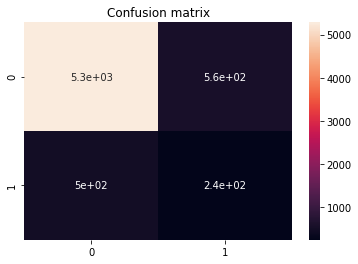

In [ ]:
#Generamos la matriz de confusión para interpretar con mayor claridad los resultados
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_val,y_val_pred)

sns.heatmap(cm, annot=True)

plt.title("Confusion matrix")   
plt.show()

En esta primera aproximación, el modelo podría estar overfiteando el conjunto de train. En ese conjunto, las métricas de precision, recall y f1 son altas para ambas clases. No obstante, al probar el modelo en el conjunto de validación, los resultados siguen siendo buenos para la clase mayoritaria pero son mucho peores para la clase minoritaria (Clase 1 - Contrató el PF).

En suma, el modelo propuesto no es muy efectivo para clasificar a los clientes que contratarían el PF (baja precision y baja recall). 

Estas conclusiones pueden observarse también por medio de la matriz de confusión del conjunto de validación. En términos de esta mariz, el objetivo es maximizar los valores que se encuentran en la diagonal princial (observaciones correctamente clasificadas para cada clase) y minimizar los valores de la diagonal secundaria (errores de clasificación de cada clase). 
En este caso puntual, el objetivo sería minimizar la cantidad de observaciones en el cuadrante inferior izquierdo, que representa clientes que contrataron el PF pero fueron clasificados por el modelo como que no lo contratarían.
O el cuadrante superior derecho, que representa clientes que no contrataron el PF pero fueron clasificados por el modelo como que si lo contratarían.

#### Cross validation

In [ ]:
# Vamos a utilizar cross validation en train set, esto nos dará aún más seguridad sobre las métricas

from sklearn.model_selection import cross_val_score
print(cross_val_score(clf, np.array(y_train).reshape(-1, 1), np.array(y_train_pred).reshape(-1, 1), cv=10))
print(cross_val_score(clf, np.array(y_val).reshape(-1, 1), np.array(y_val_pred).reshape(-1, 1), cv=10))

[0.99506829 0.99468892 0.99544765 0.99355083 0.99355083 0.99430956
 0.99430956 0.99620637 0.99430956 0.99582701]
[0.87860395 0.87860395 0.87860395 0.87708649 0.87708649 0.87708649
 0.87708649 0.87708649 0.87708649 0.87708649]


### Prueba con DT - Hiperparámetros personalizados

In [ ]:
clf = DecisionTreeClassifier(random_state=0, criterion = 'gini', max_depth = 10, min_samples_leaf = 3, min_samples_split = 2, class_weight="balanced")
clf.fit(train_dt, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
#Predecimos y obtenemos las métricas de este modelo
y_train_pred= clf.predict(train_dt)
y_val_pred=clf.predict(val_dt)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred))

print("VALIDACIÓN")
print(classification_report(y_val, y_val_pred))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.96      0.84      0.90     23390
           1       0.37      0.72      0.49      2970

    accuracy                           0.83     26360
   macro avg       0.66      0.78      0.69     26360
weighted avg       0.89      0.83      0.85     26360

VALIDACIÓN
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      5848
           1       0.31      0.60      0.41       742

    accuracy                           0.80      6590
   macro avg       0.62      0.72      0.64      6590
weighted avg       0.87      0.80      0.83      6590



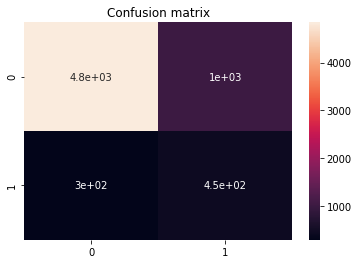

In [ ]:
#Generamos la matriz de confusión para interpretar con mayor claridad los resultados
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_val,y_val_pred)

sns.heatmap(cm, annot=True)

plt.title("Confusion matrix")   
plt.show()

En esta última matriz de confusión es posible observar que se incrementaron los casos correctamente clasificados dentro de la clase 1 (contrató PF).

#### Cross validation

In [ ]:
# Vamos a utilizar cross validation en train set, esto nos dará aún más seguridad sobre las métricas

from sklearn.model_selection import cross_val_score
print(cross_val_score(clf, np.array(y_train).reshape(-1, 1), np.array(y_train_pred).reshape(-1, 1), cv=10))
print(cross_val_score(clf, np.array(y_val).reshape(-1, 1), np.array(y_val_pred).reshape(-1, 1), cv=10))

[0.83383915 0.82738998 0.81828528 0.83345979 0.82966616 0.83042489
 0.82966616 0.82094082 0.823217   0.83004552]
[0.81487102 0.80273141 0.80424886 0.80121396 0.80576631 0.784522
 0.80728376 0.77996965 0.81335357 0.81031866]


### Guardar el modelo en formato .pkl

In [ ]:
import pickle

def save_pkl(model, pkl_filename):
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)
        
save_pkl(clf, 'best_svm_clf.pkl')